# Books Recommendation System

In [1]:
# ignore warnings especially for missing cuda driver tensorflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

2024-02-27 13:25:38.480154: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 13:25:38.530578: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 13:25:38.805918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 13:25:38.805990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 13:25:38.860045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Data Understanding

In [3]:
# load books dataset
df_books = pd.read_csv("dataset/Books.csv", low_memory=False, encoding="utf-8")
df_books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [4]:
# load ratings dataset
df_ratings = pd.read_csv("dataset/Ratings.csv")
df_ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [5]:
# load users dataset
df_users = pd.read_csv("dataset/Users.csv")
df_users.head(3)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [6]:
df_books.shape, df_ratings.shape, df_users.shape

((271360, 8), (1149780, 3), (278858, 3))

Now we want to find some information from the dataset, like data type, checking null values, doing some analysis, and EDA.

### Books

In [7]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [8]:
df_books["ISBN"].nunique(), df_books["Book-Author"].nunique(), df_books["Publisher"].nunique()

(271360, 102022, 16807)

We know that there are 271.360 unique books, 1022.022 unique authors, and 16.807 unique publisher.

In [9]:
# display top publication years
df_books["Year-Of-Publication"].value_counts().head(10)

Year-Of-Publication
2002    17627
1999    17431
2001    17359
2000    17232
1998    15766
1997    14890
2003    14358
1996    14030
1995    13546
1994    11796
Name: count, dtype: int64

In [10]:
# display top book authors
df_books["Book-Author"].value_counts().head(10)

Book-Author
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        372
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: count, dtype: int64

In [11]:
# display top publishers
df_books["Publisher"].value_counts().head(10)

Publisher
Harlequin                   7535
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3646
Scholastic                  3160
Simon &amp; Schuster        2971
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Name: count, dtype: int64

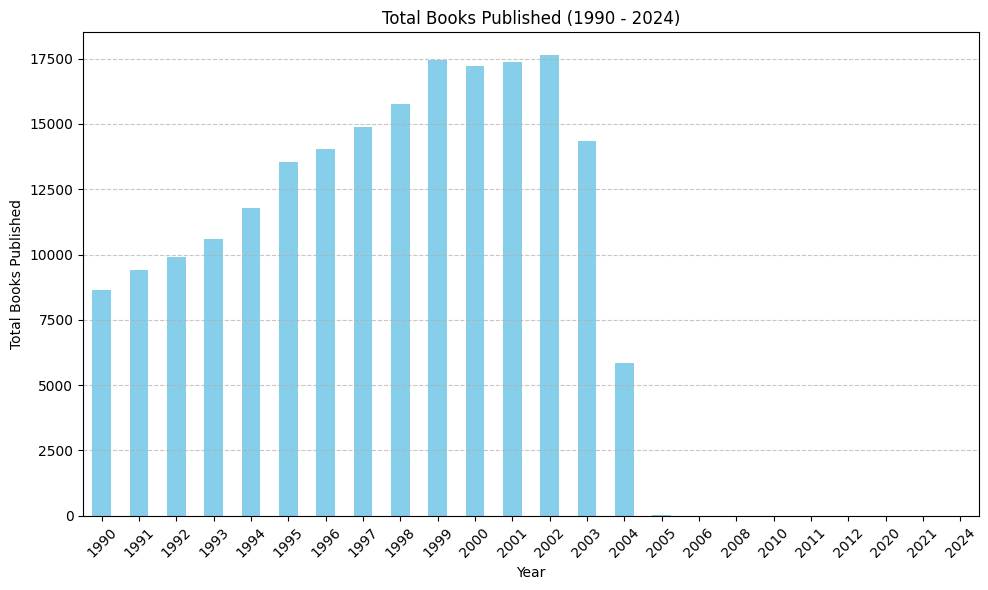

In [72]:
df_int_publication = df_books[df_books["Year-Of-Publication"].astype(str).str.isnumeric()]
df_int_publication["Year-Of-Publication"] = pd.to_datetime(df_int_publication["Year-Of-Publication"], format="%Y", errors='coerce')

current_year = datetime.now().year
books = df_int_publication[(df_int_publication["Year-Of-Publication"] >= pd.to_datetime('1990')) & (df_int_publication["Year-Of-Publication"] <= pd.to_datetime(current_year, format='%Y'))]

books_per_year = books.groupby(books["Year-Of-Publication"].dt.year).size()

plt.figure(figsize=(10, 6))
books_per_year.plot(kind='bar', color='skyblue')
plt.title('Total Books Published (1990 - {})'.format(current_year))
plt.xlabel('Year')
plt.ylabel('Total Books Published')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("docs/book-published.png")
plt.show()

### Ratings

In [13]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [14]:
df_ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


From the table above, we know that the average rating is 2.8, the minimum rating is 0 and the maximum rating is 10.

In [15]:
df_ratings["Book-Rating"].value_counts()

Book-Rating
0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: count, dtype: int64

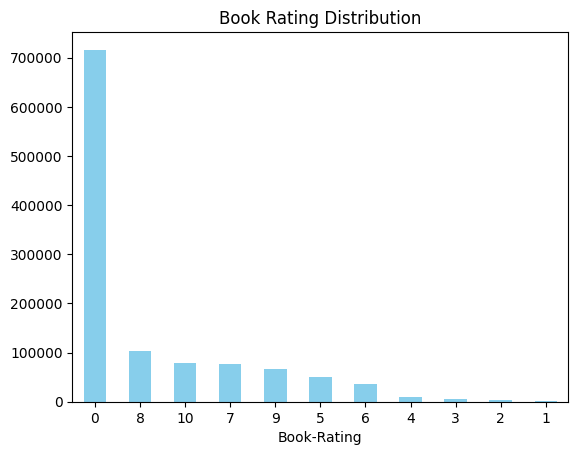

In [75]:
df_ratings["Book-Rating"].value_counts().plot(kind='bar', color='skyblue', title='Book Rating Distribution')
plt.xticks(rotation=0)
plt.savefig("docs/book-rating.png")

From the illustration above, most of the rating is 0, and then followed by 8 and 10.

In [17]:
df_ratings.groupby("User-ID")["Book-Rating"].count().sort_values(ascending=False).head(10)

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
Name: Book-Rating, dtype: int64

From the data above, we can see that the top user that gives rating is user with ID 11676.

In [18]:
top_10_most_ratings = df_ratings.groupby("ISBN")["Book-Rating"].count().sort_values(ascending=False).reset_index().head(10)
top_10_most_ratings = top_10_most_ratings.join(df_books.set_index("ISBN"), on="ISBN")
top_10_most_ratings[["Book-Rating", "ISBN", "Book-Title", "Book-Author"]]


,Book-Rating,ISBN,Book-Title,Book-Author
0,2502,0971880107,Wild Animus,Rich Shapero
1,1295,0316666343,The Lovely Bones: A Novel,Alice Sebold
2,883,0385504209,The Da Vinci Code,Dan Brown
3,732,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
4,723,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant
5,647,044023722X,A Painted House,John Grisham
6,639,0679781587,NaN,NaN
7,615,0142001740,The Secret Life of Bees,Sue Monk Kidd
8,614,067976402X,Snow Falling on Cedars,David Guterson
9,586,0671027360,Angels &amp; Demons,Dan Brown


From the table above, we know that the top 10 book that received most rating. The "Wild Animus" book received 2502 rating from users.

### Users

In [19]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [20]:
df_users.dropna().describe()

,User-ID,Age
count,168096.000000,168096.000000
mean,139394.611865,34.751434
std,80561.659564,14.428097
min,2.000000,0.000000
25%,69914.750000,24.000000
50%,139363.500000,32.000000
75%,209162.500000,44.000000
max,278855.000000,244.000000


From the table above, we konw that the user age average is about 34 years. However the max year and the minimum years seem to have an outlier that should be removed.

In [21]:
df_users["User-ID"].nunique()

278858

We know that the there are 278.858 difference users from the dataset.

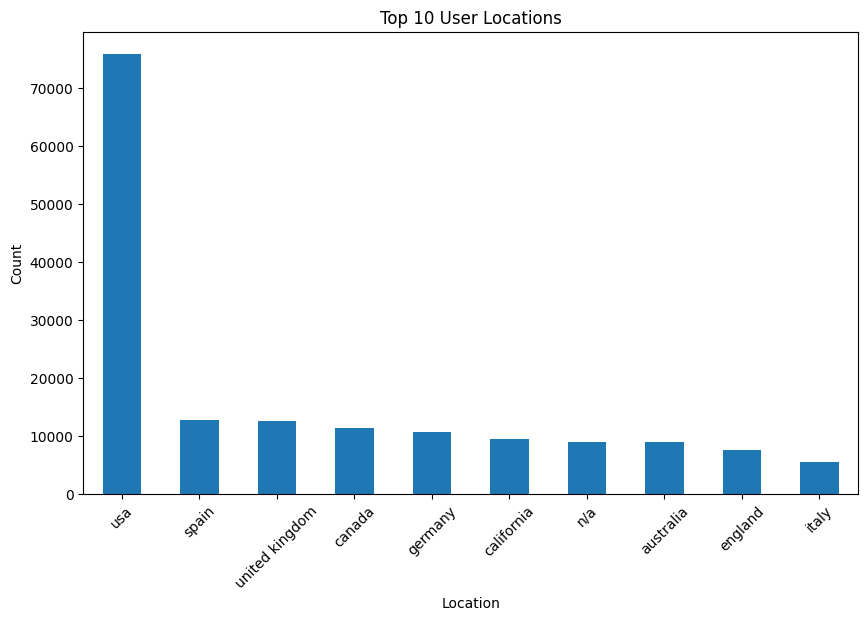

In [76]:
locations = df_users['Location'].str.split(',\s*', expand=True).stack()

location_counts = locations.value_counts()

top_locations = location_counts.head(10)

top_locations.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 User Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig("docs/user-location.png")
plt.show()

From the image above, we know that most of the users are came from USA, Canada, and California. After that we get users from UK and Germany.

## Data Preparation

In [23]:
# drop null values
df_books = df_books.dropna()
df_ratings = df_ratings.dropna()
df_users = df_users.dropna()

In [24]:
# drop duplicates values
df_books = df_books.drop_duplicates(subset=["ISBN"])
df_users = df_users.drop_duplicates(subset=["User-ID"])

In [25]:
# drop outlier age values in user using IQR
Q1 = df_users["Age"].quantile(0.25)
Q3 = df_users["Age"].quantile(0.75)
IQR = Q3 - Q1
df_users = df_users[~((df_users["Age"] < (Q1 - 1.5 * IQR)) | (df_users["Age"] > (Q3 + 1.5 * IQR)))]

Next, we will need to merge all of the data, from books, ratings, and users together.

In [26]:
all_df = pd.merge(df_ratings, df_books, on="ISBN", how="inner")
all_df = pd.merge(all_df, df_users, on="User-ID", how="inner")
all_df.head(3)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,"h, new south wales, australia",16.0
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0


In [27]:
all_df = all_df[["User-ID", "ISBN", "Book-Rating", "Book-Title"]]
all_df.head(3)

,User-ID,ISBN,Book-Rating,Book-Title
0,276727,0446520802,0,The Notebook
1,276729,052165615X,3,Help!: Level 1
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...


In [28]:
all_df.shape    

(748401, 4)

In [29]:
all_df.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
Book-Title     0
dtype: int64

In [30]:
all_df.duplicated().sum()

0

We already have the final dataset that contain 748.401 row data.

## Modeling

### Content-Based Filtering

We will try to use TFIDF and Cosine Similarty to give book recommendation based on Book Title. But we will limit the data because it's very heavy and consume a lot of memory.

In [31]:
df_cb_books = df_books[["ISBN", "Book-Title", "Book-Author"]]
df_cb_books = df_cb_books.head(20000)

In [32]:
# drop duplicates values
df_cb_books.drop_duplicates(subset="Book-Title", keep="first", inplace=True)

In [33]:
# drop null values
df_cb_books = df_cb_books.dropna()

In [34]:
# create tfidf vectorizer
tfidf = TfidfVectorizer()

In [35]:
# fit and transform the vectorizer
tfidf_matrix = tfidf.fit_transform(df_cb_books['Book-Author'])
tfidf_matrix.shape

(18797, 8836)

In [36]:
# create cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix) 

In [37]:
# create df for cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_cb_books['Book-Author'], columns=df_cb_books['Book-Title'])

We will create function to retrive book that are similar by using the cosine similarity matrix.

In [38]:
def books_recommendations(
    book_name,
    similarity_data=cosine_sim_df,
    items=df_cb_books[["Book-Title", "Book-Author"]],
    k=5,
):
    index = similarity_data.loc[:, book_name].to_numpy().argpartition(range(-1, -k, -1))

    closest = similarity_data.columns[index[-1 : -(k + 2) : -1]]

    closest = closest.drop(book_name, errors="ignore")

    return pd.DataFrame(closest).merge(items).head(k)

Now we will find some book and try to get the recommendation.

In [39]:
df_cb_books[df_cb_books["Book-Title"] == "Hearts in Atlantis"]

,ISBN,Book-Title,Book-Author
7686,0743436210,Hearts in Atlantis,Stephen King


In [40]:
books_recommendations("Hearts in Atlantis")

,Book-Title,Book-Author
0,Everything's Eventual : 14 Dark Tales,Stephen King
1,LA Niebla/Skeleton Crew,Stephen King
2,The Stand: The Complete &amp; Uncut Edition,Stephen King
3,The Green Mile: Coffey's Hands (Green Mile Ser...,Stephen King
4,The Girl Who Loved Tom Gordon,Stephen King


Nice, we successfully get some of book recommendation from the same author.

### Collaborative Filtering

Now we will use collaborative filtering that use user rating to recommend the books.

In [41]:
all_df.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276727,0446520802,0,The Notebook
1,276729,052165615X,3,Help!: Level 1
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...
3,276733,2080674722,0,Les Particules Elementaires
4,276747,0060517794,9,Little Altars Everywhere


Next we will encode the user id and book ISBN.

In [42]:
user_ids = all_df["User-ID"].unique().tolist()
encode_user = {id: i for i, id in enumerate(user_ids)}

book_ids = all_df["ISBN"].unique().tolist()
encode_book = {id: i for i, id in enumerate(book_ids)}

In [43]:
data = all_df.copy()

In [44]:
data["user"] = data["User-ID"].map(encode_user)
data["book"] = data["ISBN"].map(encode_book)
data["rating"] = data["Book-Rating"].apply(lambda x: x / 10)

In [45]:
data = data[["user", "book", "rating"]]
data.head()

,user,book,rating
0,0,0,0.0
1,1,1,0.3
2,1,2,0.6
3,2,3,0.0
4,3,4,0.9


In [46]:
num_users = data["user"].nunique()
num_books = data["book"].nunique()
num_users, num_books

(53489, 228187)

After that, we will split it into training and testing.

In [47]:
X = data[["user", "book"]].values
y = data["rating"].values

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

After that, we will build a recommender class for this recommendation problem.

In [49]:
class BookRecommender(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(BookRecommender, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.user_embedding = keras.layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = keras.layers.Embedding(num_users, 1)
        self.book_embedding = keras.layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.book_bias = keras.layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        x = dot_user_book + user_bias + book_bias
        return tf.nn.sigmoid(x)

We will compile the model using loss binary crossentropy, with Adam optimizer, and RMSE metrics.

In [51]:
model = BookRecommender(num_users, num_books, 128)
 
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Fit the model

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 1024,
    epochs = 10,
    validation_data = (X_test, y_test),
    verbose = 0
)

Plot the training history

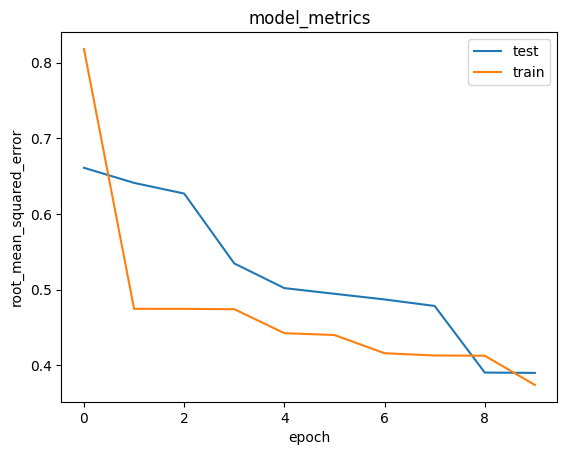

In [69]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Now we will try to make recommendation to a random user.

In [135]:
user_id = df_ratings["User-ID"].sample(1).iloc[0]
books_read_by_user = df_ratings[df_ratings["User-ID"] == user_id]
books_read_by_user

,User-ID,ISBN,Book-Rating
982585,236283,0007114818,0
982586,236283,0020442408,0
982587,236283,0030018897,10
982588,236283,0060002492,0
982589,236283,0060176172,0
...,...,...,...
983909,236283,67120484X,0
983910,236283,671788698,0
983911,236283,671802712,0
983912,236283,684717557,0


In [136]:
book_not_read = df_books[~df_books["ISBN"].isin(books_read_by_user["ISBN"])]
book_not_read = list(
    set(book_not_read["ISBN"]).intersection(set(encode_book.keys()))
)
book_not_read[:5]

['0061097101', '067131825X', '0590442929', '0936839856', '0856487643']

In [137]:
book_not_read = [[encode_book.get(x)] for x in book_not_read]
book_not_read[:5]

[[525], [186041], [174898], [207670], [21194]]

In [138]:
user_encode = encode_user.get(user_id)
user_encode

45962

In [139]:
user_books_array = np.hstack(
    ([[user_encode]] * len(book_not_read), book_not_read)
)
user_books_array

array([[ 45962,    525],
       [ 45962, 186041],
       [ 45962, 174898],
       ...,
       [ 45962,  50866],
       [ 45962,  96754],
       [ 45962, 109379]])

In [140]:
user_books_array.shape

(227774, 2)

In [141]:
ratings = model.predict(user_books_array).flatten()

7118/7118 [==============================] - 11s 1ms/step


In [142]:
top_ratings_indices = ratings.argsort()[-10:][::-1]
top_ratings_indices

array([126116,  16977,  21533, 169485,  90702, 168085,  15972, 152752,
        15998,  15968])

In [143]:
new_books_df = df_books.copy()
new_books_df["id"] = new_books_df["ISBN"].map(encode_book)
new_books_df = new_books_df.dropna()

In [144]:
top_10_books = new_books_df[new_books_df["id"].isin(top_ratings_indices)][["Book-Title", "Book-Author"]].reset_index(drop=True)
top_10_books

,Book-Title,Book-Author
0,Out of Nowhere,Doris Mortman
1,Situation Ethics: The New Morality,Joseph Francis Fletcher
2,Learning to Say No: Establishing Healthy Bound...,Carla Wills-Brandon
3,Der Untertan: Roman,Heinrich Mann
4,The Invoker (Lawson Vampire Novels),Jon F. Merz
5,Les Voies d'Anubis,Tim Powers
6,Bad Boys on Board,Lori Foster
7,Lonely Planet New York City: Condensed (Lonely...,Dani Valent
8,Nature's Green Umbrella: Tropical Rain Forests,Gail Gibbons
9,The Anatomy Coloring Book (2nd Edition),Wynn Kapit
